# Определение возраста покупателей

## Исследовательский анализ данных

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/. 
В вашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. 
Нам необходимо Извлечь данные из папки нам поможет новый метод ImageDataGenerator —flow_from_dataframe(dataframe, directory, ...).
Задание 1
Проведем исследовательский анализ данных:
Посмотрим на размер выборки.
Построим график распределения возраста в выборке.
Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150,150),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


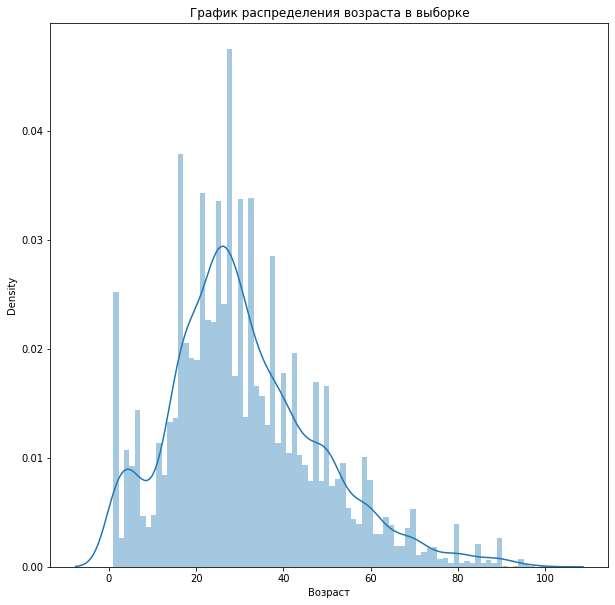

In [10]:
plt.figure(figsize=(10,10))
sns.distplot(data['real_age'], bins=80)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст');


In [6]:
print(data.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


In [7]:
data.isna().sum()

file_name    0
real_age     0
dtype: int64

In [8]:
data.duplicated().sum()

0

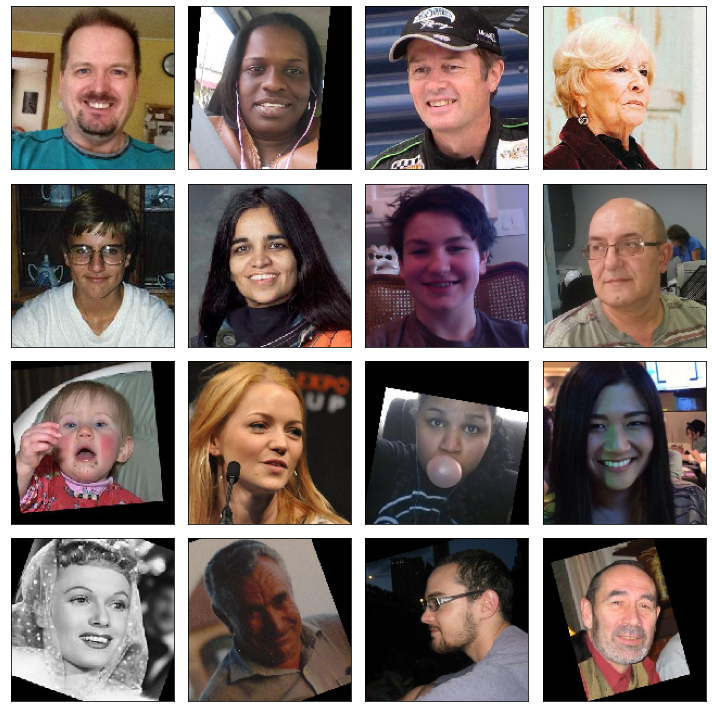

In [9]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вывод:

В базе  содержится 7591 фотография.
Больше всего фотографий в диапазоне от 20 до 41 года. Всего в базе фотографии от 1 до 100 лет.
Фотографии в базе под разным углом, с разным фоном и с различными помехами около лица (рука, микрофон, жевательная резинка, ремеь безопасности и т.п.). Фото различаются по качеству и по яркости.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                      horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150,150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150,150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

380/380 - 51s - loss: 217.3473 - mae: 10.6822 - val_loss: 432.9881 - val_mae: 15.5920
Epoch 2/5
380/380 - 43s - loss: 86.5628 - mae: 7.0436 - val_loss: 143.9965 - val_mae: 9.0254
Epoch 3/5
380/380 - 43s - loss: 60.8727 - mae: 5.9351 - val_loss: 87.5270 - val_mae: 7.3034
Epoch 4/5
380/380 - 43s - loss: 45.4101 - mae: 5.1206 - val_loss: 72.1164 - val_mae: 6.3303
Epoch 5/5
380/380 - 44s - loss: 31.1038 - mae: 4.2626 - val_loss: 81.5626 - val_mae: 6.9490
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 8s - loss: 81.5626 - mae: 6.9490
Test MAE: 6.9490

```

Вывод: Модель нейронной сети построена на ResNet50. На 5 эпохах обучилась до значения MAE 6.94, что соответствует условиям задания.

## Анализ обученной модели


Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Построена модель, которая по фотографии определит приблизительный возраст человека. Проанализирован набор фотографий людей с указанием возраста при помощи компьютерного зрения с привлечением готовых нейронных сетей и библиотеки Keras.

Была создана нейронная сеть с архитектурой ResNet, с применением сверточных сетей, преобученых на ImageNet. 
Обучение модели проходит в 5 эпох с алгоритмом Adam (оптимизатор), где learning_rate = 0.0001, размер батча 16, заморозка весов не использовалась.
Обученная модель позволяет определить возраст покупателя по фото с погрешностью 6-7 лет.

Мы достигли требуемой точности MAE = 6.94 предсказания возраста нашей моделью. Результаты метрики во время обучения только улучшались, это говорит о том, что модель не переобучалась и мы можем увеличить количество эпох и изменить размер изображений (Модель ResNEt обучалась на изображениях размером 224х224), тогда значение метрики может уменьшиться.
Вывод: Мы можем рекомендовать нашу модель к использованию.